# ML4ReferenceAlignment tutorial

**Purpose:** generating a partial reference alignment for ontology matching tool evaluation.  
**Methods**: training a machine learning model to learn what a correct alignment looks like, by using the outputs of the ontology matching tools that have participated in previous OAEI tracks as *features* and the quality  manual reference alignment available for each of those tracks as *target*.

## Table of contents 

0. [Data](#data)
1. [Preprocessing](#preprocessing)
2. [Training the models](#training)
3. [Evaluating the models](#evaluation)
4. [Classifying a new instance](#classification)

# 0. Data <a id = "data"></a>

The data used in these experiments is available in the OAEI website. To train and test the models, you will need two types of datasets:
 -  alignments outputted by the participating OM tools in the OAEI competition (rdf files); we will have one rdf file per participating tool, for each track. Here we have the links for the 2019 results (originally used in this work).
	 - Anatomy track: http://oaei.ontologymatching.org/2019/results/anatomy/oaei2019-anatomy-alignments.zip
	 - LargeBioMed track: http://www.cs.ox.ac.uk/isg/projects/SEALS/oaei/2019/results/largebio-results-2019.zip
	 - Conference track: http://oaei.ontologymatching.org/2019/conference/data/conference2019results.zip
     
- the reference alignment provided for each track
    - Anatomy track: http://oaei.ontologymatching.org/2019/anatomy/anatomy-dataset.zip (reference.rdf)
    - LargeBioMed track: http://www.cs.ox.ac.uk/isg/projects/SEALS/oaei/2019/LargeBio_dataset_oaei2019.zip (oaei_ont1ont2_UMLS_mappings_with_flagged_repairs.rdf files)
	- Conference track: http://oaei.ontologymatching.org/2019/conference/data/reference-alignment.zip

Despite this, one could virtually use any other dataset as long as there is a reference available. It's important to keep in mind that the higher the quality of the reference alignment, the higher the chances of developing a well performing model.

<img src=https://i.pinimg.com/originals/4d/23/43/4d2343fe4228140e84af25cddd809659.jpg width="300">

# 1. Preprocessing <a id = "preprocessing"></a>

In order to feed our machine learning models with training examples, we want to have this kind of data structure:

![image](https://user-images.githubusercontent.com/43668147/99803653-bf6e4980-2b31-11eb-81d6-45aff638e47c.png)

However, a processing step is needed to obtain this kind of data structure from the raw outputs of the tools. 

In [103]:
import utils as u
import numpy as np
import random
import os
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

### 1.1. Load the outputs of the participating tools (features) and the reference alingnment (target)

Extract fields *entity 1*, *entity 2*, *measure* using the method ```extract_mappings()``` (in utils.py).

In the case where the track contains more than two ontologies (e.g. LargeBio and Conference datasets) the process of extracting the mappings produced by each tool is multiplied by the number of possible alignments between the ontologies available. In this case, a function such as ```read_rdf()``` (in utils.py) could be useful.

In [104]:
# LOAD ANATOMY
an_dir = os.path.join("data","anatomy-2019")
an_agm = u.extract_mappings(os.path.join(an_dir, "AGM.rdf"))
an_aml = u.extract_mappings(os.path.join(an_dir, "AML.rdf"))
an_dome = u.extract_mappings(os.path.join(an_dir, "DOME.rdf"))
an_fcamap = u.extract_mappings(os.path.join(an_dir, "FCAMap-KG.rdf"))
an_logmap = u.extract_mappings(os.path.join(an_dir, "LogMap.rdf"))
an_logmapbio = u.extract_mappings(os.path.join(an_dir, "LogMapBio.rdf"))
an_logmaplt = u.extract_mappings(os.path.join(an_dir, "LogMapLt.rdf"))
an_pomappp = u.extract_mappings(os.path.join(an_dir, "POMAP++.rdf"))
an_wiktionary = u.extract_mappings(os.path.join(an_dir, "Wiktionary.rdf"))  

an_tools = {
        "agm": an_agm,
        "aml": an_aml,
        "dome": an_dome,
        "fcamap": an_fcamap,
        "logmap": an_logmap,
        "logmapbio": an_logmapbio,
        "logmaplt": an_logmaplt,
        "pomap++": an_pomappp,
        "wiktionary": an_wiktionary,
    }

# Reference
df_an_ref = u.extract_mappings(os.path.join(an_dir, "reference.rdf"), is_ref=True)

In [105]:
# LOAD LARGEBIO (FMA-NCI)
lb_measures = [
    'measure_agm',
    'measure_aml',
    'measure_dome',
    'measure_fcamap',
    'measure_logmap',
    'measure_logmapbio',
    'measure_logmaplt',
    'measure_pomap++',
    'measure_wiktionary'
]

lb_data_path = os.path.join("data", "largebio-2019")

#Data and reference
df_lb, df_lb_ref = u.read_rdf(ont1='fma', 
                              ont2='nci', 
                              measures=lb_measures, 
                              track='largebio', 
                              data_path=lb_data_path, 
                              ref_path= os.path.join(lb_data_path, "oaei_fma_nci_mappings_with_flagged_repairs.rdf"),
                              data_processed_path=os.path.join(lb_data_path,"data_lb.csv"), 
                              ref_processed_path=os.path.join(lb_data_path,"ref_lb.csv"))

File already exists


### 1.3. Merge all data into one dataframe

In [106]:
#Antomy
df_an = u.merge_mappings(an_tools)
df_an = df_an.merge(df_an_ref, how='outer',on=["entity1", "entity2"])
df_an.rename(columns={"measure": "label"}, inplace=True)

In [107]:
#Largebio
df_lb = df_lb.merge(df_lb_ref, how='outer',on=["entity1", "entity2"])
df_lb.rename(columns={"measure": "label"}, inplace=True)

### 1.4. Fill in the missing values - negative sampling

Right now the data has some missing values:

In [108]:
df_an.head()

,entity1,entity2,measure_agm,measure_aml,measure_dome,measure_fcamap,measure_logmap,measure_logmapbio,measure_logmaplt,measure_pomap++,measure_wiktionary,label
0,http://mouse.owl#genid1728,http://human.owl#NCI_C33170,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://mouse.owl#MA_0000342,http://human.owl#genid4462,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://mouse.owl#genid1416,http://human.owl#genid4717,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://mouse.owl#MA_0001235,http://human.owl#genid1248,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://mouse.owl#MA_0001052,http://human.owl#NCI_C33187,1.0,0.846,NaN,NaN,NaN,0.96,1.0,1.0,0.166667,1.0


This is because we outter merged all of the tools outputs and not all tools contain the same mappings. 
We also have missing values in the classification label, since the reference alignment only encompasses positives examples. Thus, by filling in the missing values with label 0, we proceed to create negative examples, i.e. mappings that would be classified as incorrect by the tools that ommitted those mappings in the final output.

In [109]:
# Missing values
df_an.fillna(0)
df_lb.fillna(0)

,entity1,entity2,measure_agm,measure_aml,measure_dome,measure_fcamap,measure_logmap,measure_logmapbio,measure_logmaplt,measure_pomap++,measure_wiktionary,label
0,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00
1,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00
2,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00
3,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00
4,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1.0,0.9801,0.0,1.0,0.73,0.73,1.0,0.0,1.0,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...
14404,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.41
14405,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.41
14406,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.34
14407,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.45


### 1.5. Make the data binary

In our experiments, we found that the models that were fed with binary data showed the best results. One possible explanation for this is that the different tools use different score thresholds for selecting mappings to include in the final output, which means that a given score could mean a correct mapping for a tool but an incorrect one to another. Having no appropriate way to normalize these scores, we decided to make the data binary. Thus, ``1`` represents a correct mapping according to that OM system, and ``0`` represents an incorrect mapping.

In [110]:
#Make data binary
X_bins_an = u.bin_features(df_an, 0,1)
X_bins_lb = u.bin_features(df_lb,0,1)

In [111]:
#Labelled dataset
Xy_bins_an = X_bins_an.copy()
Xy_bins_lb = X_bins_lb.copy()

#Unlabelled dataset for training
X_bins_an.drop('label', axis=1)
X_bins_lb.drop('label', axis=1)

,entity1,entity2,measure_agm,measure_aml,measure_dome,measure_fcamap,measure_logmap,measure_logmapbio,measure_logmaplt,measure_pomap++,measure_wiktionary
0,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1,0,0,0,0,0,0,0,0
1,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1,0,0,0,0,0,0,0,0
2,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1,0,0,0,0,0,0,0,0
3,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1,0,0,0,0,0,0,0,0
4,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
14404,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0,0,0,0,0,0,0,0,0
14405,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0,0,0,0,0,0,0,0,0
14406,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0,0,0,0,0,0,0,0,0
14407,http://bioontology.org/projects/ontologies/fma...,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,0,0,0,0,0,0,0,0,0


### 1.5. Exploratory data analysis

Here we have the number of positive and negative examples. The data imbalance will be tackled later.

In [112]:
## NUMBER OF NEGATIVE AND POSITIVE EXAMPLES
Xy_bins_an['label'].value_counts()

0    1960
1    1516
Name: label, dtype: int64

In [113]:
Xy_bins_lb['label'].value_counts()

0    11403
1     3006
Name: label, dtype: int64

By looking at the correlation between each feature and the label, one could get a glimpse on the features' importance.

In [114]:
print(Xy_bins_an.corr()['label'])

measure_agm          -0.645437
measure_aml           0.899889
measure_dome          0.675455
measure_fcamap        0.687745
measure_logmap        0.791106
measure_logmapbio     0.809404
measure_logmaplt      0.738062
measure_pomap++       0.818384
measure_wiktionary    0.742290
label                 1.000000
Name: label, dtype: float64


In [115]:
print(Xy_bins_lb.corr()['label'])

measure_agm          -0.326691
measure_aml           0.783928
measure_dome          0.663104
measure_fcamap        0.640909
measure_logmap        0.779242
measure_logmapbio     0.755499
measure_logmaplt      0.672930
measure_pomap++      -0.230332
measure_wiktionary    0.687324
label                 1.000000
Name: label, dtype: float64


# 2. Training the models <a id = "training"></a>

For the training, tuning and testing of the models, we apply a mega function, ```utils.train_and_eval()```. This function takes as parameters:
   - **cross_tuples**: A list of tuples with the following shape: 
        ```(*[Training DataFrames], *[Testing DataFrames], name : string)```
   - **classifiers**: list of classifier classes
   - **classifier_kwargs**: list of dictionaries that will be used as keyword arguments for the classifier. If the kwargs includes a key 'param_grid' with a dictionary of value ranges, the optimum hyperparameters will be searched for using a GridSearch.
   - **missing_feature_strategy**: Either intersection or substitution. Intersection will remove the non-common features. Substitution will substitute the prediction of the missing tool with a 0.
   - **undersample**: Boolean. Indicates whether to try undersampling.
   - **save**: String. Path to which the pickled dataframe will be saved. Enabling this function might be useful since the dataframe contains information on the objects of the classifiers (beta coefficients, weights, etc.), which may be used for further analysis. 
   - **save_rate**: The rate of save, in number of models trained. Every N models, the results are saved.
   
***Warning: this step might take some time - use the 'results_anatomy.pkl' file for a quick overview of the resulting models.***

In [116]:
# In this case we will be training the models using the anatomy dataset 
# and testing them with the largebio dataset.
# Notice that the features (tools used) in the two datasets are the same - this is mandatory
# If the participating tools in each of the tracks are not the same, 
# we could only consider the intersection of those tools.

cross_tuples=[([Xy_bins_an], [Xy_bins_lb], "anatomy-lb")]

In [117]:
#DEFINE CLASSIFIERS & ARGS
classifiers = [
    RandomForestClassifier,
    KNeighborsClassifier,
    DecisionTreeClassifier,
    MLPClassifier,
    GaussianNB,
    GradientBoostingClassifier,
    LogisticRegression,
    AdaBoostClassifier
]

classifier_kwargs = [
    {"param_grid": {'n_estimators': list(range(50,250,50)) , 'criterion': ['gini', 'entropy']}},
    {"param_grid": {'n_neighbors': list(range(1,7)), 'p': [1,2]}},
    {"param_grid": {'criterion': ['gini', 'entropy']}},
    {"param_grid": {'hidden_layer_sizes':[(10,), (40,), (100,), (10, 10), (40, 40), (100, 100)], 'learning_rate_init': [0.01, 0.05, 0.1,]}},
    {"param_grid": {}},
    {"param_grid": {'n_estimators':list(range(50,250,50)),'learning_rate':[0.01, 0.1, 0.2]}},
    {"param_grid": {'C':[0.1,0.5,1,10], 'tol': [1e-2,1e-3,1e-4]}},
    {"param_grid": {'base_estimator': [LogisticRegression()], 'n_estimators': [50,100,150,200]}}
]

In [118]:
# Warning: this step might take some time - skip to the next cell  
# for a quick overview of the resulting models.
df_results = u.train_and_eval(cross_tuples, classifiers, classifier_kwargs, undersample=True, save='results_anatomy-lb.pkl')

Sampling Strategy:   0%|          | 0/2 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/8 [00:00<?, ?it/s]

Classifiers:  12%|█▎        | 1/8 [00:36<04:16, 36.69s/it]

Classifiers:  25%|██▌       | 2/8 [01:07<03:29, 34.86s/it]

Classifiers:  38%|███▊      | 3/8 [01:10<02:06, 25.23s/it]

Classifiers:  50%|█████     | 4/8 [02:57<03:19, 49.93s/it]

Classifiers:  62%|██████▎   | 5/8 [02:58<01:46, 35.35s/it]

Classifiers:  75%|███████▌  | 6/8 [03:24<01:04, 32.40s/it]

Classifiers:  88%|████████▊ | 7/8 [03:37<00:26, 26.55s/it]

Classifiers: 100%|██████████| 8/8 [04:02<00:00, 26.07s/it]

                                                          
Sampling Strategy:  50%|█████     | 1/2 [04:02<04:02, 242.34s/it]

Classifiers:   0%|          | 0/8 [00:00<?, ?it/s]

Classifiers:  12%|█▎        | 1/8 [00:25<03:00, 25.82s/it]

Classifiers:  25%|██▌       | 2/8 [00:53<02:38, 26.49s/it]

Classifiers:  38%|███▊      | 3/8 [00:55<01:35, 19.15s/it]

Classifiers:  50%|█████     | 4/8 [02:35<02:52, 43.2

In [119]:
# OR use previously ran models
import pickle
df_results = pickle.load(open("results_anatomy-lb.pkl","rb"))

In [120]:
df_results.head()

,name,measures,classifier,testing_df,sampling_strategy,f1_train,f1_test,acc_test,recall_test,precision_test,grid_search,classifier_name
11,anatomy-lb,"[measure_fcamap, measure_wiktionary, measure_a...","(TomekLinks(n_jobs=-1), MLPClassifier(hidden_l...",...,undersample,0.923471,0.866981,0.941287,0.917166,0.822004,"GridSearchCV(cv=10,\n estimator=Pi...","(DecisionTreeClassifier(max_features='auto', r..."
3,anatomy-lb,"[measure_fcamap, measure_wiktionary, measure_a...","(SMOTETomek(n_jobs=-1, random_state=42), MLPCl...",...,oversample,0.930885,0.860143,0.938996,0.899202,0.824337,"GridSearchCV(cv=10,\n estimator=Pi...","KNeighborsClassifier(n_neighbors=6, p=1)"
10,anatomy-lb,"[measure_fcamap, measure_wiktionary, measure_a...","(TomekLinks(n_jobs=-1), DecisionTreeClassifier())",...,undersample,0.921918,0.832152,0.927684,0.859281,0.806683,"GridSearchCV(cv=10,\n estimator=Pi...",DecisionTreeClassifier()
14,anatomy-lb,"[measure_fcamap, measure_wiktionary, measure_a...","(TomekLinks(n_jobs=-1), LogisticRegression(C=1...",...,undersample,0.922076,0.831339,0.928586,0.843646,0.819386,"GridSearchCV(cv=10,\n estimator=Pi...","MLPClassifier(hidden_layer_sizes=(40,), learni..."
7,anatomy-lb,"[measure_fcamap, measure_wiktionary, measure_a...","(SMOTETomek(n_jobs=-1, random_state=42), (Logi...",...,oversample,0.920097,0.830354,0.927545,0.849967,0.811626,"GridSearchCV(cv=10,\n estimator=Pi...",GaussianNB()


The results dataset contains the following information:
- **name**: name given to the experiment
- **measures**: the set of ontology matching tools that were used as features
- **classifier**: pipeline used for the training of the models - object with the form ``Pipeline(sampling strategy, classifier)``
- **testing_df**: contains the dataframe that was used for testing
- **sampling_strategy**: the data balancement strategy used (either undersampling or oversampling)
- **f1_train**: the f1-score obtained in the training phase (cross-evaluation). In this case, this corresponds to the evaluation within the``anatomy`` dataset.
- **f1_test**: the f1-score obtained in the testing phase. In this case, this corresponds to the evaluation with the ``largebio`` dataset.
- **acc_test**: the accuracy obtained in the testing phase.
- **recall_test**: the recall obtained in the testing phase.
- **precision_test**: the precision obtained in the testing phase.
- **grid_search**:the parameters defined for the grid search and cross validation
- **classifier_name**: the classifier object. This object could be used for the classification of novel instances (see how in section [4](#classification))

# 3. Evaluating the models <a id = "evaluation"></a>

------
Top:1
Sampling strategy: undersample
F1 Train: 0.923
F1 Test: 0.867
Accuracy Test: 0.941             
Precision Test: 0.822
Recall Test: 0.917
------
Top:2
Sampling strategy: oversample
F1 Train: 0.931
F1 Test: 0.860
Accuracy Test: 0.939             
Precision Test: 0.824
Recall Test: 0.899
------
Top:3
Sampling strategy: undersample
F1 Train: 0.922
F1 Test: 0.832
Accuracy Test: 0.928             
Precision Test: 0.807
Recall Test: 0.859


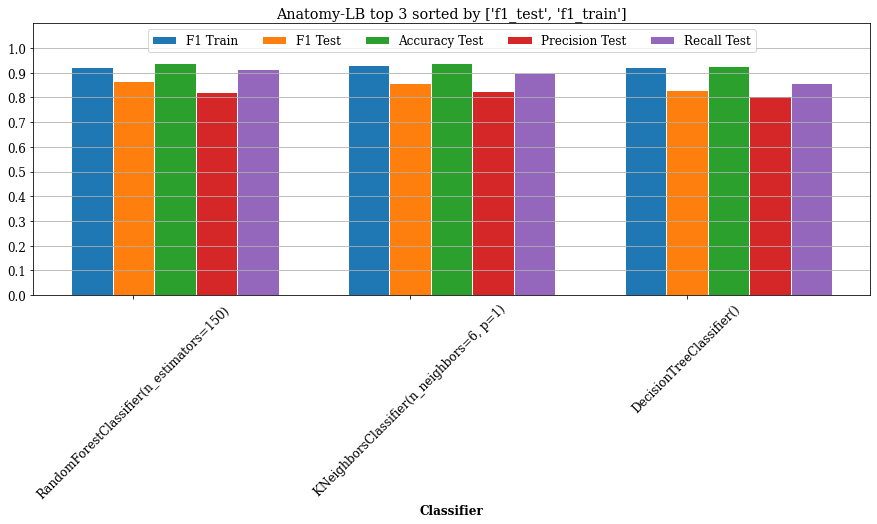

In [121]:
u.plot_top_results(df_results[df_results['name']=='anatomy-lb'],'Anatomy-LB',sort_by=['f1_test', 'f1_train'], top=3, logs = True)

[Text(0, 0.5, ''), Text(0.5, 0, ''), Text(0.5, 1.0, 'Test')]

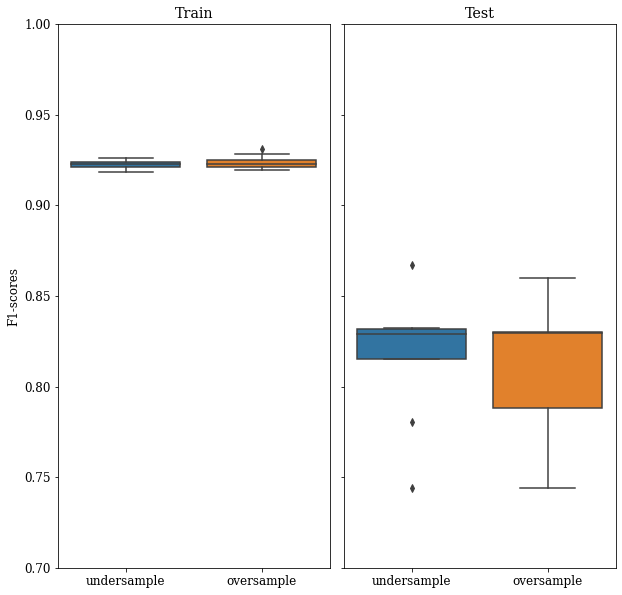

In [122]:
import matplotlib.pyplot as plt

# Plot font and sizes
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('font', family='serif')

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,10))
plt.subplots_adjust(wspace = 0.05)
plt.ylim(0.7, 1.0)

#Boxplots
sns.boxplot(x="sampling_strategy", 
            y="f1_train", 
            data=df_results[df_results['name']=='anatomy-lb'], 
            ax=axes[0]).set(xlabel=None,ylabel='F1-scores',title='Train')

#Boxplots
sns.boxplot(x="sampling_strategy", 
            y="f1_test", 
            data=df_results[df_results['name']=='anatomy-lb'], 
            ax=axes[1]).set(xlabel=None,ylabel=None,title='Test')

Looking at these results, we can conclude that the models trained with the ``Anatomy`` dataset were able to perform well within the same alignment (``Train F1-score``) but when tested against the ``LargeBio`` dataset, the performance was impaired. This is a sign of overfitting. Still, the overall F1-scores are high.

# 4. Classifying a new instance <a id = "classification"></a>

In [123]:
classifier = df_results['classifier_name'][11] #best classifier
new_mapping_1 = [1, 0, 0, 0, 1, 0, 1, 0, 0] #pattern of tools' outputs
new_mapping_2 = [1, 0, 0, 0, 0, 0, 1, 0, 1]

print("The mapping", new_mapping_1, "is predicted to be: ", classifier.predict([new_mapping_1]))
print("The mapping", new_mapping_2, " is predicted to be: ", classifier.predict([new_mapping_2]))

The mapping [1, 0, 0, 0, 1, 0, 1, 0, 0] is predicted to be:  [0]
The mapping [1, 0, 0, 0, 0, 0, 1, 0, 1]  is predicted to be:  [1]


Where ``0`` represents an incorrect mapping and ``1`` means a correct mapping.

---
### Authors
Beatriz Lima, Cátia Pesquita
    
### License
See the [LICENSE.md](https://github.com/liseda-lab/ML4ReferenceAlignment/blob/master/LICENSE) file for details.
    
### Acknowledgments
This project was funded by the FCT through LASIGE Research Unit, ref. UIDB/00408/2020 and ref. UIDP/00408/2020, and by projects SMILAX (ref. PTDC/EEI-ESS/4633/2014).